<a href="https://colab.research.google.com/github/robertosgpontes/osem/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Formulação do Problema

O problema apresentado pode ser formulado através de uma

\begin{equation}
	\max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i}
\end{equation}
e
\begin{equation}
\min \sum_{i=1}^{n}{C_iX_i}
\end{equation}


Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [220]:
% pip install pulp

https://www.supplychaindataanalytics.com/multi-objective-linear-optimization-with-pulp-in-python/

https://pythonhealthcare.org/tag/pareto-front/

In [221]:
# Python libraries used to solve the problem Linear Programing
import pulp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [222]:
NUM_ITER = 1000

In [223]:
# Variáveis do modelo

A1 = np.array([11.444, 0.047, 1.523, 0.095])
A2 = np.array([0.899, 0.0, 0.926, 0.073]) 
A3 = np.array([0.00106, 0.00010, 0.00021, 0.00006])
C = np.array([1.41, 4.99, 2.41, 6.24])
A = np.array([  [1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [1, 0, 1, 0],
                [1, 1, 1, 1],
                [1, 0, 0, 0],
                [0, 1, 0, 0]])

b = np.array([[557],[1143],[1577],[1700],[10310],[160],[6990]])

In [224]:
def create_x_variables():
    x1 = pulp.LpVariable("x1",lowBound = 0) 
    x2 = pulp.LpVariable("x2",lowBound = 0)
    x3 = pulp.LpVariable("x3",lowBound = 0) 
    x4 = pulp.LpVariable("x4",lowBound = 0) 
    return np.array([[x1], [x2], [x3], [x4]]) 

In [225]:
def load_model(lpm, A, X, b):
    Ax = A.dot(X)

    for i in range(0,4):
        lpm += Ax[i,0] <= b[i,0]

    lpm += Ax[4,0] == b[4,0]

    for i in range(5,7):
        lpm += Ax[i,0] >= b[i,0]

    return lpm

# Approach 1: Solution with Hierarchical Methodology

Maximizing for one objective, then adding it as a constraint and solving for the other objective

## 1.1. First Step

\begin{equation}
S_1 = \max  \sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [226]:
linearProblem = pulp.LpProblem("First_Objective_Max",pulp.LpMaximize)

X = create_x_variables()

f1 = (A1 - (A2 + A3))*X.T

linearProblem += f1.sum()

linearProblem = load_model(linearProblem, A, X, b)

linearProblem.writeLP('modelStep1.lp')

solution = linearProblem.solve()

f1_max = pulp.value(linearProblem.objective)

In [227]:
# print(linearProblem)

In [228]:
print("#1 - " + str(pulp.LpStatus[solution])+" ; max value = "+str(pulp.value(linearProblem.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

#1 - Optimal ; max value = 6958.914550000001 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


## 1.1. Second Step


\begin{equation}
\min \sum_{i=1}^{n}{C_iX_i}
\end{equation}
Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 = b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} \geq S_1
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}


In [229]:
linearProblem2 = pulp.LpProblem("Second_Objective_Min",pulp.LpMinimize)

X = create_x_variables()

linearProblem2 += C.dot(X)[0]

linearProblem2 = load_model(linearProblem2, A, X, b)

f1 = (A1 - (A2 + A3))*X.T

linearProblem2 += f1.sum() >= f1_max

linearProblem2.writeLP('modelStep2.lp')

solution2 = linearProblem2.solve()

In [230]:
print(linearProblem2)

Second_Objective_Min:
MINIMIZE
1.41*x1 + 4.99*x2 + 2.41*x3 + 6.24*x4 + 0.0
SUBJECT TO
_C1: x1 <= 557

_C2: x3 <= 1143

_C3: x4 <= 1577

_C4: x1 + x3 <= 1700

_C5: x1 + x2 + x3 + x4 = 10310

_C6: x1 >= 160

_C7: x2 >= 6990

_C8: 10.54394 x1 + 0.0469 x2 + 0.59679 x3 + 0.02194 x4 >= 6958.91455

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous
x4 Continuous



In [231]:
print(str(pulp.LpStatus[solution2])+" ; max value = "+str(pulp.value(linearProblem2.objective))+
      " ; x1_opt = "+str(pulp.value(X[0][0]))+
      " ; x2_opt = "+str(pulp.value(X[1][0]))+
      " ; x3_opt = "+str(pulp.value(X[2][0]))+
      " ; x4_opt = "+str(pulp.value(X[3][0])))

Optimal ; max value = 46503.9 ; x1_opt = 557.0 ; x2_opt = 8610.0 ; x3_opt = 1143.0 ; x4_opt = 0.0


# 2. Solution with ...

\begin{equation}
	\max  \alpha\sum_{i=1}^{n}{[A_{i}^1-(A_{i}^2-A_{i}^3)]X_i} - (1-\alpha)\sum_{i=1}^{n}{C_iX_i}
\end{equation}

Sujeito a
\begin{equation}
x_1 \leq b_1
\end{equation}
\begin{equation}
x_2 \leq b_2
\end{equation}
\begin{equation}
x_3 \leq b_3
\end{equation}
\begin{equation}
x_1 + x_3 \leq b_4
\end{equation}
\begin{equation}
x_1 + x_2 + x_3 + x_4 \leq b_5
\end{equation}
\begin{equation}
x_1 \geq b_6
\end{equation}
\begin{equation}
x_2 \geq b_7
\end{equation}
\begin{equation}
x_1, x_2, x_3, x_4 \geq 0
\end{equation}

In [232]:
def f_alpha(alpha, f1, f2):
  return (alpha*f1 - (1-alpha)*f2)

In [233]:
def run_models(f_alphas):
  solution_lst = []
  i = 0
  for alpha in f_alphas:
    model = pulp.LpProblem("MultiObjetivo",pulp.LpMaximize)

    X = create_x_variables()

    f1 = (A1 - (A2 + A3))*X.T
    f1 = f1.sum()

    f2 = C.dot(X)[0]

    model += f_alpha(alpha, f1, f2)

    model = load_model(model, A, X, b)

    solution = model.solve()

    X2 = np.array([pulp.value(X[0][0]), 
                    pulp.value(X[1][0]), 
                    pulp.value(X[2][0]), 
                    pulp.value(X[3][0])])
    
    solution_lst.append([i,
                    alpha,
                    str(pulp.LpStatus[solution]),
                    pulp.value(X[0][0]), 
                    pulp.value(X[1][0]), 
                    pulp.value(X[2][0]), 
                    pulp.value(X[3][0]),
                    pulp.value(model.objective),
                    ((A1 - (A2 + A3))*X2.T).sum(),
                    C.dot(X2)]
                    )
    i += 1
    
  return pd.DataFrame(solution_lst, columns=["iter","alpha","status","x1","x2", "x3", "x4", "obj_value", "f1", "f2"])

In [234]:
sig = lambda sigma: 1/(1 + np.exp(sigma*(np.linspace(0, NUM_ITER, NUM_ITER)-(NUM_ITER/2))))

In [235]:
f_alpha_lin = np.linspace(0, 1, NUM_ITER)

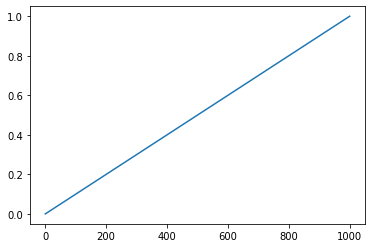

In [236]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), f_alpha_lin)

In [237]:
df_solution_lin = run_models(f_alpha_lin)

-1.41*x1 - 4.99*x2 - 2.41*x3 - 6.24*x4
-1.398034094094094*x1 - 4.984958058058059*x2 - 2.4069902002002004*x3 - 6.233731791791792*x4
-1.386068188188188*x1 - 4.979916116116117*x2 - 2.4039804004004006*x3 - 6.227463583583584*x4
-1.3741022822822822*x1 - 4.974874174174174*x2 - 2.4009706006006004*x3 - 6.221195375375375*x4
-1.3621363763763763*x1 - 4.969832232232233*x2 - 2.397960800800801*x3 - 6.2149271671671675*x4
-1.3501704704704705*x1 - 4.96479029029029*x2 - 2.3949510010010013*x3 - 6.208658958958959*x4
-1.3382045645645646*x1 - 4.959748348348349*x2 - 2.3919412012012016*x3 - 6.202390750750752*x4
-1.3262386586586588*x1 - 4.954706406406407*x2 - 2.388931401401402*x3 - 6.196122542542543*x4
-1.3142727527527527*x1 - 4.9496644644644645*x2 - 2.3859216016016016*x3 - 6.189854334334335*x4
-1.3023068468468468*x1 - 4.944622522522523*x2 - 2.382911801801802*x3 - 6.1835861261261265*x4
-1.2903409409409408*x1 - 4.939580580580581*x2 - 2.3799020020020025*x3 - 6.177317917917918*x4
-1.278375035035035*x1 - 4.93453863

In [238]:
df_solution_lin

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.000000,Optimal,557.0,8610.0,1143.0,0.0,-46503.900000,6958.91455,46503.9
1,1,0.001001,Optimal,557.0,8610.0,1143.0,0.0,-46450.383669,6958.91455,46503.9
2,2,0.002002,Optimal,557.0,8610.0,1143.0,0.0,-46396.867338,6958.91455,46503.9
3,3,0.003003,Optimal,557.0,8610.0,1143.0,0.0,-46343.351007,6958.91455,46503.9
4,4,0.004004,Optimal,557.0,8610.0,1143.0,0.0,-46289.834676,6958.91455,46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,0.995996,Optimal,557.0,8610.0,1143.0,0.0,6744.849226,6958.91455,46503.9
996,996,0.996997,Optimal,557.0,8610.0,1143.0,0.0,6798.365557,6958.91455,46503.9
997,997,0.997998,Optimal,557.0,8610.0,1143.0,0.0,6851.881888,6958.91455,46503.9
998,998,0.998999,Optimal,557.0,8610.0,1143.0,0.0,6905.398219,6958.91455,46503.9


In [239]:
f_alpha_sig_004 = sig(-0.004)

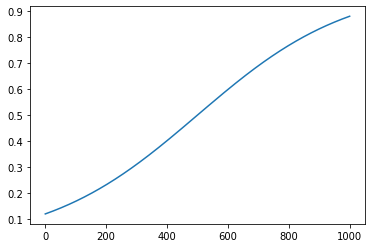

In [240]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), f_alpha_sig_004)

In [241]:
df_solution_sig_004 = run_models(f_alpha_sig_004)

0.014944577677072024*x1 - 4.3895868020667965*x2 - 2.0515818460931174*x3 - 5.49355845447282*x4
0.019977618350228488*x1 - 4.387466085167881*x2 - 2.0503158788584117*x3 - 5.490921951469388*x4
0.025026013303491856*x1 - 4.3853388986051165*x2 - 2.049046049541757*x3 - 5.488277405295186*x4
0.030089792252635306*x1 - 4.383205229857495*x2 - 2.0477723506687084*x3 - 5.485624800383935*x4
0.035168984847426366*x1 - 4.3810650664318205*x2 - 2.0464947747814204*x3 - 5.48296412120393*x4
0.04026362067054623*x1 - 4.378918395863166*x2 - 2.0452133144389224*x3 - 5.48029535225861*x4
0.04537372923650107*x1 - 4.376765205715326*x2 - 2.043927962217393*x3 - 5.477618478087123*x4
0.050499339990530245*x1 - 4.374605483581288*x2 - 2.042638710710433*x3 - 5.474933483264906*x4
0.05564048230751317*x1 - 4.37243921708368*x2 - 2.041345552529341*x3 - 5.472240352404253*x4
0.060797185490861994*x1 - 4.370266393875248*x2 - 2.0400484803033923*x3 - 5.469539070154891*x4
0.06596947877141979*x1 - 4.368087001639312*x2 - 2.0387474866801143*x

In [242]:
df_solution_sig_004

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,0.119203,Optimal,557.0,8610.0,1143.0,0.0,-40130.976286,6958.91455,46503.9
1,1,0.119624,Optimal,557.0,8610.0,1143.0,0.0,-40108.466509,6958.91455,46503.9
2,2,0.120046,Optimal,557.0,8610.0,1143.0,0.0,-40085.888062,6958.91455,46503.9
3,3,0.120470,Optimal,557.0,8610.0,1143.0,0.0,-40063.240812,6958.91455,46503.9
4,4,0.120895,Optimal,557.0,8610.0,1143.0,0.0,-40040.524625,6958.91455,46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,0.879105,Optimal,557.0,8610.0,1143.0,0.0,495.539175,6958.91455,46503.9
996,996,0.879530,Optimal,557.0,8610.0,1143.0,0.0,518.255362,6958.91455,46503.9
997,997,0.879954,Optimal,557.0,8610.0,1143.0,0.0,540.902612,6958.91455,46503.9
998,998,0.880376,Optimal,557.0,8610.0,1143.0,0.0,563.481059,6958.91455,46503.9


In [243]:
f_alpha_sig_06 = sig(-0.06)

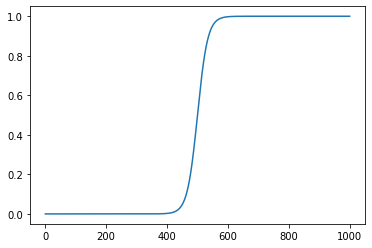

In [244]:
plt.plot(np.linspace(0, NUM_ITER, NUM_ITER), f_alpha_sig_06)

In [245]:
df_solution_sig_06 = run_models(f_alpha_sig_06)

-1.4099999999988813*x1 - 4.989999999999529*x2 - 2.4099999999997186*x3 - 6.239999999999414*x4
-1.409999999998812*x1 - 4.9899999999995*x2 - 2.4099999999997013*x3 - 6.2399999999993785*x4
-1.4099999999987385*x1 - 4.989999999999468*x2 - 2.409999999999683*x3 - 6.239999999999339*x4
-1.4099999999986605*x1 - 4.989999999999436*x2 - 2.409999999999663*x3 - 6.2399999999992986*x4
-1.4099999999985775*x1 - 4.989999999999401*x2 - 2.409999999999642*x3 - 6.239999999999255*x4
-1.4099999999984896*x1 - 4.989999999999363*x2 - 2.40999999999962*x3 - 6.239999999999209*x4
-1.409999999998396*x1 - 4.989999999999324*x2 - 2.409999999999597*x3 - 6.23999999999916*x4
-1.4099999999982966*x1 - 4.989999999999283*x2 - 2.409999999999572*x3 - 6.239999999999108*x4
-1.4099999999981911*x1 - 4.989999999999238*x2 - 2.4099999999995454*x3 - 6.2399999999990525*x4
-1.4099999999980795*x1 - 4.989999999999191*x2 - 2.409999999999517*x3 - 6.239999999998994*x4
-1.4099999999979602*x1 - 4.9899999999991405*x2 - 2.409999999999487*x3 - 6.239999

In [246]:
df_solution_sig_06

,iter,alpha,status,x1,x2,x3,x4,obj_value,f1,f2
0,0,9.357623e-14,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
1,1,9.936863e-14,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
2,2,1.055196e-13,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
3,3,1.120513e-13,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
4,4,1.189873e-13,Optimal,557.0,8610.0,1143.0,0.0,-46503.90000,6958.91455,46503.9
...,...,...,...,...,...,...,...,...,...,...
995,995,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9
996,996,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9
997,997,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9
998,998,1.000000e+00,Optimal,557.0,8610.0,1143.0,0.0,6958.91455,6958.91455,46503.9


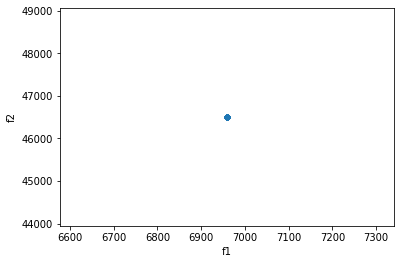

In [248]:
df_solution_sig_06.plot.scatter(x='f1', y='f2')